# IMPORT DATA AND REMOVE OUTLIERS

## Import Data:

In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')

df_original = pd.read_csv('result/data/melting_point_features.csv')

## REMOVE OUTLIERS

In [11]:
print("--- BẮT ĐẦU XỬ LÝ & CHIA DỮ LIỆU ---")
df_clean = df_original.dropna(subset=['Tm'])

df_clean = df_clean[(df_clean['Tm'] > 0) & (df_clean['Tm'] < 4000)].copy()

print(f"1. Dữ liệu sau khi lọc: {len(df_clean)} dòng (Đã loại {len(df_original) - len(df_clean)} nhiễu)")

y = df_clean['Tm']
X = df_clean.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X_final = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    y_log, 
    test_size=0.2, 
    random_state=2601
)

y_test_real = np.expm1(y_test)

print("-" * 30)
print(f"✅ HOÀN TẤT! Dữ liệu đã sạch và được chia:")
print(f"   - X_train: {X_train.shape} | y_train (Log): {y_train.shape}")
print(f"   - X_test : {X_test.shape}  | y_test  (Log): {y_test.shape}")

--- BẮT ĐẦU XỬ LÝ & CHIA DỮ LIỆU ---
1. Dữ liệu sau khi lọc: 8766 dòng (Đã loại 1754 nhiễu)
------------------------------
✅ HOÀN TẤT! Dữ liệu đã sạch và được chia:
   - X_train: (7012, 937) | y_train (Log): (7012,)
   - X_test : (1754, 937)  | y_test  (Log): (1754,)


# MODEL TRAINING: FEATURES SELECTION USING RFECV, GA 

## RFECV Train

In [3]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import joblib
import numpy as np

print("\n--- 2. CHẠY RFECV ---")
start = time.time()

model_rfe = LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=2601,
    n_jobs=-1, verbose=-1
)

rfe = RFECV(
    estimator=model_rfe,
    min_features_to_select=50,
    step=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1
)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFECV Selected: {len(selected_rfe)} features")

joblib.dump(list(selected_rfe), 'result/rfe_features.pkl')

print("\n--- 3. ĐÁNH GIÁ ---")
eval_model = LGBMRegressor(
    n_estimators=3000, learning_rate=0.01, num_leaves=50, max_depth=-1,
    subsample=0.8, colsample_bytree=0.7, random_state=2601, n_jobs=-1, verbose=-1
)

eval_model.fit(X_train[selected_rfe], y_train)

y_pred_log = eval_model.predict(X_test[selected_rfe])

y_pred_real = np.expm1(y_pred_log)

y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("\n" + "="*40)
print("📊 KẾT QUẢ RFECV (REAL SCALE)")
print(f"Features : {len(selected_rfe)}")
print(f"MAE      : {mae:.4f} K")
print(f"RMSE     : {rmse:.4f} K")
print(f"R2       : {r2:.4f}")
print("="*40)


--- 2. CHẠY RFECV ---
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.
Fitting estimator with 617 features.
Fitting estimator with 597 features.
Fitting estimator with 577 features.
Fitting estimator with 557 features.
⏱️ Time Run: 334.77 s
✅ RFECV Selected: 537 features

--- 3. ĐÁNH GIÁ ---

📊 KẾT QUẢ RFECV (REAL SCALE)
Features : 537
MAE      : 83.3528 K
RMSE     : 193.6333 K
R2       : 0.5936


## GENETIC ALGORITHM (GA) Train

In [13]:
from sklearn_genetic import GAFeatureSelectionCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import joblib
import numpy as np

print("\n--- 2. CHẠY GENETIC ALGORITHM (GA) ---")
start = time.time()

model_ga = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31, 
    ax_depth=-1,
    random_state=2601,
    n_jobs=1, verbose=-1
)

ga = GAFeatureSelectionCV(
    estimator=model_ga,
    cv=3,
    scoring="neg_mean_absolute_error",
    population_size=50,
    generations=15,
    mutation_probability=0.1,
    crossover_probability=0.8,
    keep_top_k=2,
    elitism=True,
    n_jobs=-1, verbose=True
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Chosen {len(selected_ga)} features")
joblib.dump(list(selected_ga), 'result/ga_features.pkl')

print("\n--- 3. ĐÁNH GIÁ (EVALUATION) ---")
eval_model = LGBMRegressor(
    n_estimators=3000, learning_rate=0.01, num_leaves=50, max_depth=-1,
    subsample=0.8, colsample_bytree=0.7, random_state=2601, n_jobs=-1, verbose=-1
)

eval_model.fit(X_train[selected_ga], y_train)

y_pred_log = eval_model.predict(X_test[selected_ga])

y_pred_real = np.expm1(y_pred_log)

y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("\n--- RESULT GA (REAL SCALE) ---")
print(f"Features: {len(selected_ga)}")
print(f"MAE     : {mae:.4f} K")
print(f"RMSE    : {rmse:.4f} K")
print(f"R2      : {r2:.4f}")


--- 2. CHẠY GENETIC ALGORITHM (GA) ---
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.313244	0.00164074 	-0.310662  	-0.316698  
1  	87    	-0.31168 	0.0011927  	-0.309466  	-0.314696  
2  	89    	-0.31074 	0.00109904 	-0.308686  	-0.313999  
3  	90    	-0.310119	0.000918291	-0.308364  	-0.311778  
4  	89    	-0.309898	0.000893461	-0.308364  	-0.3126    
5  	92    	-0.309493	0.000939631	-0.307558  	-0.312634  
6  	87    	-0.308973	0.000769522	-0.307558  	-0.310964  
7  	90    	-0.308804	0.00084929 	-0.307096  	-0.311671  
8  	88    	-0.308657	0.000649408	-0.307776  	-0.310393  
9  	90    	-0.308403	0.000802651	-0.307137  	-0.310853  
10 	84    	-0.30825 	0.00077616 	-0.307137  	-0.310731  
11 	90    	-0.308031	0.000723326	-0.307137  	-0.310725  
12 	96    	-0.307969	0.000582144	-0.306868  	-0.30921   
13 	87    	-0.307531	0.000531833	-0.306305  	-0.308572  
14 	96    	-0.307341	0.000872157	-0.305877  	-0.310652  
15 	88    	-0.306893	0.000657008	-0.305838  	-0.

# UNION 2 MODEL

In [4]:
import joblib

rfe_features = joblib.load('result/rfe_features.pkl')
ga_features = joblib.load('result/ga_features.pkl')

common_features = set(rfe_features) | set(ga_features)

print(f"\n💎 Tổng features sau khi gộp (Union): {len(common_features)}")
print(list(common_features))


💎 Tổng features sau khi gộp (Union): 739
['Morgan_115', 'Morgan_146', 'Morgan_449', 'MACCS_66', 'Morgan_161', 'SMR_VSA6', 'Chi1n', 'fr_benzene', 'SlogP_VSA3', 'Morgan_112', 'Morgan_308', 'Morgan_181', 'Morgan_144', 'Morgan_466', 'Morgan_423', 'Morgan_89', 'Chi4v', 'MACCS_105', 'Rings56_frac', 'Morgan_504', 'Morgan_221', 'SMR_VSA8', 'MaxPartialCharge', 'fr_epoxide', 'Morgan_459', 'Morgan_381', 'Morgan_385', 'MACCS_158', 'MolMR', 'FracDouble', 'Morgan_358', 'Chi1v', 'fr_dihydropyridine', 'Morgan_102', 'Morgan_507', 'MACCS_16', 'SlogP_VSA9', 'MACCS_85', 'Morgan_73', 'Count_O', 'Morgan_94', 'Morgan_490', 'MACCS_157', 'Morgan_187', 'BCUT2D_MRLOW', 'Morgan_475', 'Morgan_43', 'SlogP_VSA10', 'Morgan_468', 'Morgan_217', 'NumHeteroatoms', 'Morgan_69', 'Morgan_292', 'Morgan_51', 'Morgan_163', 'Morgan_412', 'Morgan_286', 'Morgan_465', 'Morgan_84', 'Morgan_348', 'Chi0v', 'Morgan_129', 'MaxAbsEStateIndex', 'Morgan_79', 'MACCS_155', 'MACCS_53', 'Morgan_125', 'Morgan_274', 'MACCS_89', 'Morgan_245', '

# CHOICE BEST FEATURES

In [54]:
import joblib
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log, test_size=0.2, random_state=2601
)

best_features = list(common_features)
valid_features = [f for f in best_features if f in X_final.columns]

manual_params = {
    'n_estimators': 8000,
    'learning_rate': 0.01,
    'num_leaves': 40,
    'max_depth': 15,
    'min_child_samples': 20,
    
    'objective': 'regression',
    'metric': 'rmse',
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

final_model = LGBMRegressor(**manual_params)

final_model.fit(X_train[valid_features], y_train)

joblib.dump(final_model, 'result/final_melting_point_model.pkl')
joblib.dump(valid_features, 'result/final_features_list.pkl')

print("💾 Đã lưu model và features thành công!")

💾 Đã lưu model và features thành công!


# SCORING

## Score Combine Features

In [55]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = joblib.load('result/final_melting_point_model.pkl')
features = joblib.load('result/final_features_list.pkl')

print(f"✅ Đã load model. Đang đánh giá trên tập Test có sẵn ({len(X_test)} mẫu)...")

y_pred_raw = model.predict(X_test[features])

if y_test.max() > 15:
    y_test_real_eval = y_test
    print("ℹ️ Phát hiện y_test là thang đo Thực (giữ nguyên).")
else:
    y_test_real_eval = np.expm1(y_test)
    print("ℹ️ Phát hiện y_test là thang đo Log (đã chuyển về Thực    ).")

if y_pred_raw.max() > 15:
    y_pred_real = y_pred_raw
else:
    y_pred_real = np.expm1(y_pred_raw)

mae = mean_absolute_error(y_test_real_eval, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real_eval, y_pred_real))
r2 = r2_score(y_test_real_eval, y_pred_real)

print("\n--- 🏁 FINAL RESULT (REAL SCALE) ---")
print(f"MAE : {mae:.4f} K")
print(f"RMSE: {rmse:.4f} K")
print(f"R2  : {r2:.4f}")

✅ Đã load model. Đang đánh giá trên tập Test có sẵn (1713 mẫu)...
ℹ️ Phát hiện y_test là thang đo Log (đã chuyển về Thực    ).

--- 🏁 FINAL RESULT (REAL SCALE) ---
MAE : 63.5788 K
RMSE: 96.1689 K
R2  : 0.6298


## Score each Model

In [29]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]

    if not valid_feats: 
        return {"Method": name, "Features": 0, "R2": 0, "MAE": 0, "RMSE": 0}

    model = LGBMRegressor(
        n_jobs=-1, verbose=-1, random_state=2601,
        n_estimators=5000, learning_rate=0.01,
        num_leaves=31, max_depth=-1, subsample=0.8,
        colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=0.1
    )
    
    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False)]

    model.fit(X_train[valid_feats], y_train, 
              eval_set=[(X_test[valid_feats], y_test)],
              eval_metric='rmse', callbacks=callbacks)

    y_pred_real = np.expm1(model.predict(X_test[valid_feats], num_iteration=model.best_iteration_))
    y_test_real = np.expm1(y_test)

    return {
        "Method": name, "Features": len(valid_feats),
        "R2": r2_score(y_test_real, y_pred_real),
        "MAE": mean_absolute_error(y_test_real, y_pred_real),
        "RMSE": np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    }

feats_all = list(X_train.columns)
try: feats_rfe = joblib.load('result/rfe_features.pkl')
except: feats_rfe = []
try: feats_ga = joblib.load('result/ga_features.pkl')
except: feats_ga = []

results = [get_metrics("Original", feats_all)]
if feats_rfe: results.append(get_metrics("RFE", feats_rfe))
if feats_ga: results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
if not df_res.empty:
    base = df_res.iloc[0]
    df_res['Diff_R2'] = df_res['R2'] - base['R2']
    df_res['Diff_MAE'] = df_res['MAE'] - base['MAE']
    df_res['Diff_RMSE'] = df_res['RMSE'] - base['RMSE']
    
    print("\n" + "="*40)
    print(df_res.round(4).to_string(index=False))
    
    common = set(feats_rfe) & set(feats_ga)
    print(f"\n💎 Common Features ({len(common)})")
    joblib.dump(list(common_features), 'result/common_features.pkl')


  Method  Features     R2     MAE     RMSE  Diff_R2  Diff_MAE  Diff_RMSE
Original       937 0.6563 66.8168 117.0634   0.0000    0.0000     0.0000
     RFE       537 0.6552 67.3306 117.2516  -0.0011    0.5138     0.1882
      GA       473 0.6547 67.7210 117.3288  -0.0016    0.9042     0.2654

💎 Common Features (283)


# GridSearch Find Best Params

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from optuna.integration import LightGBMPruningCallback
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

if 'best_features' in globals():
    features_to_use = list(best_features)
    print(f"✅ Tuning trên danh sách 'best_features' ({len(features_to_use)} biến).")
elif 'common_features' in globals():
    features_to_use = list(common_features)
    print(f"✅ Tuning trên danh sách 'common_features' ({len(features_to_use)} biến).")
else:
    features_to_use = list(X_train.columns)
    print(f"⚠️ Không tìm thấy danh sách chọn lọc. Tuning trên toàn bộ {len(features_to_use)} biến.")

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'n_jobs': 4,
        'random_state': 2601,
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 127),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
    }
    
    X_opt = X_train[features_to_use]
    y_opt = y_train 
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2601)
    scores = []
    
    for train_idx, val_idx in cv.split(X_opt, y_opt):
        X_tr, X_val = X_opt.iloc[train_idx], X_opt.iloc[val_idx]
        y_tr, y_val = y_opt.iloc[train_idx], y_opt.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**param)
        
        pruning_callback = LightGBMPruningCallback(trial, "l1")
        
        model.fit(
            X_tr, y_tr, 
            eval_set=[(X_val, y_val)], 
            eval_metric='mae',
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                pruning_callback
            ]
        )
        
        preds = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, preds))
    
    return np.mean(scores)

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=20)

print("-" * 50)
print('🏆 Best params found:')
print(study.best_params)
print("-" * 50)

--- 🛠️ CHUẨN BỊ OPTUNA ---
✅ Tuning trên danh sách 'best_features' (739 biến).

⏳ Đang chạy Optuna để tìm tham số ngon nhất...
--------------------------------------------------
🏆 Best params found:
{'n_estimators': 1387, 'learning_rate': 0.0367662838306723, 'num_leaves': 106, 'max_depth': 10, 'subsample': 0.9125930601413169, 'colsample_bytree': 0.6308766700784241, 'reg_alpha': 2.4762261326796215, 'reg_lambda': 0.6426967506854285, 'min_child_samples': 31}
--------------------------------------------------


# Elbow GA Model

Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (39 vòng)...
   -> Dùng 471 features: R2 = 0.6285 | MAE = 64.25 | RMSE = 96.34
   -> Dùng 451 features: R2 = 0.6266 | MAE = 64.56 | RMSE = 96.58
   -> Dùng 431 features: R2 = 0.6313 | MAE = 64.03 | RMSE = 95.98
   -> Dùng 411 features: R2 = 0.6246 | MAE = 64.68 | RMSE = 96.85
   -> Dùng 391 features: R2 = 0.6304 | MAE = 64.08 | RMSE = 96.10
   -> Dùng 371 features: R2 = 0.6225 | MAE = 64.82 | RMSE = 97.11
   -> Dùng 351 features: R2 = 0.6282 | MAE = 63.83 | RMSE = 96.38
   -> Dùng 331 features: R2 = 0.6209 | MAE = 65.18 | RMSE = 97.32
   -> Dùng 311 features: R2 = 0.6204 | MAE = 64.87 | RMSE = 97.39
   -> Dùng 291 features: R2 = 0.6254 | MAE = 64.90 | RMSE = 96.74
   -> Dùng 271 features: R2 = 0.6265 | MAE = 64.71 | RMSE = 96.60
   -> Dùng 251 features: R2 = 0.6245 | MAE = 64.45 | RMSE = 96.86
   -> Dùng 231 features: R2 = 0.6226 | MAE = 65.23 | RMSE = 97.10
   -> Dùng 211 features: R2 = 0.6284 | MAE = 64.45 | RMSE = 96.35
 

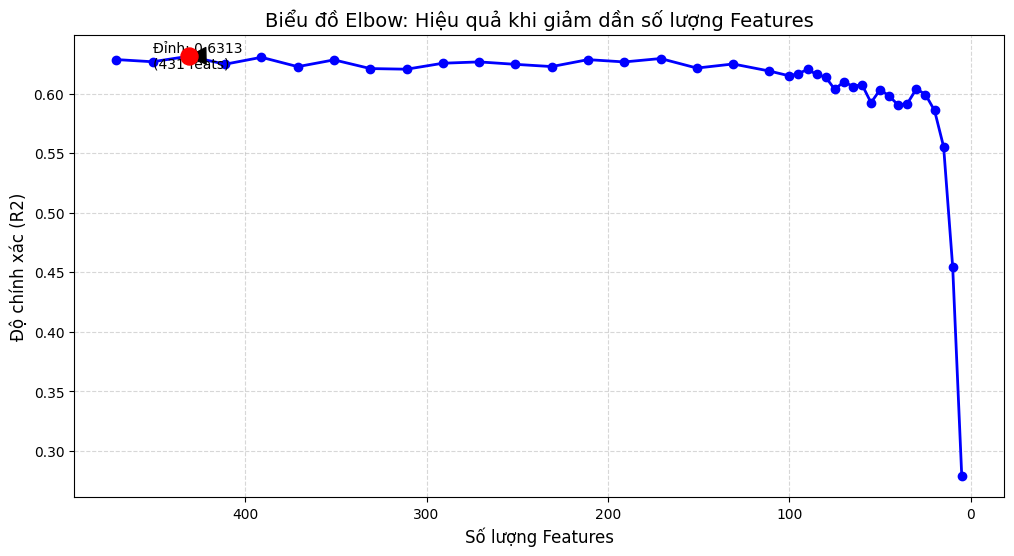


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        MAE       RMSE
0  0.631291           431  64.032001  95.978959
1  0.630391           391  64.079445  96.096096
2  0.629353           171  64.405362  96.230875
3  0.628488           471  64.245466  96.343074
4  0.628429           211  64.451709  96.350729
5  0.628231           351  63.830663  96.376364
6  0.626650           451  64.564934  96.581162
7  0.626527           271  64.709926  96.597022
8  0.626496           191  64.399306  96.601036
9  0.625415           291  64.895820  96.740786

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        MAE        RMSE
38             5  0.278851  96.179035  134.229074
37            10  0.454476  78.344299  116.745756
36            15  0.555333  71.572023  105.402630
35            20  0.585761  69.034633  101.732457
34            25  0.599123  68.085816  100.078239
33            30  0.603967  66.620822   99.471750
32            35  0.591567  67.494668  101.01708

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.05, 
    'n_estimators': 3000,
    'num_leaves': 100,
    'max_depth': 12,
    'min_child_samples': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 100, -20)) + list(range(100, 0, -5))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred_log = model.predict(X_test[current_feats])
    
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)

    r2 = r2_score(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae = mean_absolute_error(y_test_real, y_pred_real)

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | MAE = {mae:.2f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'MAE', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'MAE', 'RMSE']].head(10))

# Elbow RFECV Model


--- START RFE WITH LEADERBOARD ---
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.

Time Run: 1437.83 s
Best Number of Features: 617
Best CV R2 Score: 0.6600

LEADERBOARD (DESCENDING SCORE):
 Num_Features  Score_R2
          630  0.659951
          570  0.659921
          470  0.659856
          390  0.659811
          590  0.659810
          530  0.659741
          350  0.659711
          890  0.659697
          750  0.659697
          730  0.659697


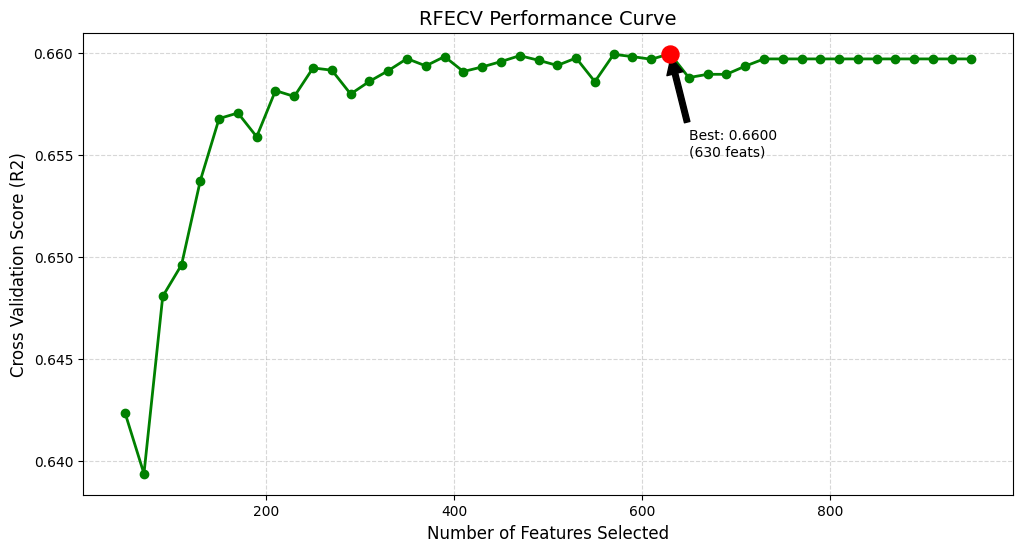


Selected Features List:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA8', 'SlogP_VSA1', 'SlogP_VSA10', '

In [31]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

print("\n--- START RFE WITH LEADERBOARD ---")
start = time.time()

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

rfecv = RFECV(
    estimator=model,
    step=20,
    cv=3,
    scoring='r2', 
    min_features_to_select=50,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train, y_train)

r2_scores = rfecv.cv_results_['mean_test_score']
n_scores = len(r2_scores)

feature_counts = [50 + i * 20 for i in range(n_scores)]

if len(feature_counts) > len(r2_scores):
    feature_counts = feature_counts[:len(r2_scores)]

df_results = pd.DataFrame({
    'Num_Features': feature_counts,
    'Score_R2': r2_scores
})

df_leaderboard = df_results.sort_values(by='Score_R2', ascending=False).reset_index(drop=True)

selected_rfecv = X_train.columns[rfecv.support_]
print(f"\nTime Run: {time.time() - start:.2f} s")
print(f"Best Number of Features: {rfecv.n_features_}")
print(f"Best CV R2 Score: {df_leaderboard.iloc[0]['Score_R2']:.4f}")

print("\nLEADERBOARD (DESCENDING SCORE):")
print(df_leaderboard.head(10).to_string(index=False))

print("\nPROGRESS (BY FEATURE COUNT):")
print(df_results.head(10).to_string(index=False))

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['Score_R2'], marker='o', color='green', linewidth=2)

best_row = df_leaderboard.iloc[0]
plt.scatter(best_row['Num_Features'], best_row['Score_R2'], color='red', s=150, zorder=5)
plt.annotate(f"Best: {best_row['Score_R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['Score_R2']), 
             xytext=(best_row['Num_Features']+20, best_row['Score_R2']-0.005),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFECV Performance Curve', fontsize=14)
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross Validation Score (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("\nSelected Features List:")
print(list(selected_rfecv))

y_pred_log = rfecv.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

test_r2 = r2_score(y_test_real, y_pred_real)
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("\n--- FINAL TEST EVALUATION (Best Features) ---")
print(f"R2 Score : {test_r2:.4f}")
print(f"MAE      : {test_mae:.4f} K")
print(f"RMSE     : {test_rmse:.4f} K")

df_results.to_csv('result/rfecv_results.csv', index=False)

# Compare before and after using partial correlation

⏳ Đang tính toán ma trận tương quan...
✂️ Đã tìm thấy 8 features trùng lặp (Corr > 0.998)
🚀 Đang chạy đánh giá lại với 929 features...

✅ Kết quả R2 Cũ (Original): 0.6563
✅ Kết quả R2 Mới (Filtered): 0.6612


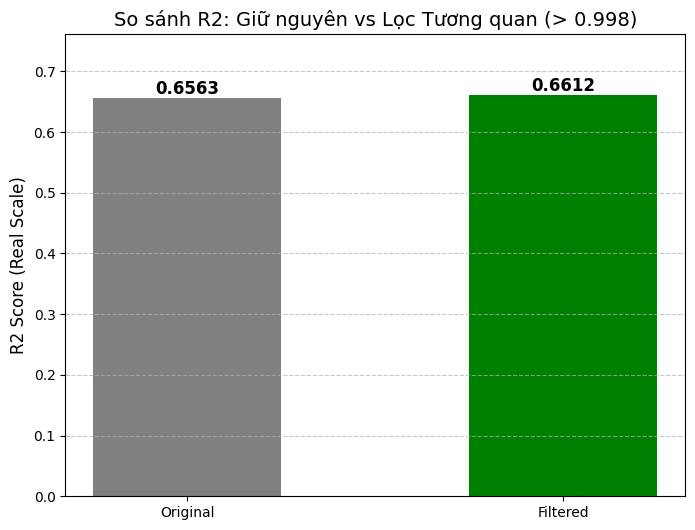

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

ULTRA_HIGH_CORR = 0.998

print("⏳ Đang tính toán ma trận tương quan...")
corr_matrix = X_train.corr().abs()

ranker_temp = LGBMRegressor(n_estimators=100, verbose=-1, random_state=2601)
ranker_temp.fit(X_train, y_train)
importances = pd.Series(ranker_temp.feature_importances_, index=X_train.columns)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = []

for column in upper.columns:
    correlated_cols = upper.index[upper[column] > ULTRA_HIGH_CORR].tolist()
    
    if correlated_cols:
        for other_col in correlated_cols:
            if other_col in to_drop: continue
            
            imp_col = importances.get(column, 0)
            imp_other = importances.get(other_col, 0)
            
            if imp_col < imp_other:
                to_drop.append(column)
                break 
            else:
                to_drop.append(other_col)

to_drop = list(set(to_drop))
print(f"✂️ Đã tìm thấy {len(to_drop)} features trùng lặp (Corr > {ULTRA_HIGH_CORR})")

if len(to_drop) > 0:
    feats_filtered = [f for f in X_train.columns if f not in to_drop]
    
    print(f"🚀 Đang chạy đánh giá lại với {len(feats_filtered)} features...")
    res_filtered = get_metrics(f"Filtered (Corr > {ULTRA_HIGH_CORR})", feats_filtered)
    
    new_r2 = res_filtered['R2']
    
    old_r2 = df_res.loc[df_res['Method'] == 'Original', 'R2'].values[0]
    
    print(f"\n✅ Kết quả R2 Cũ (Original): {old_r2:.4f}")
    print(f"✅ Kết quả R2 Mới (Filtered): {new_r2:.4f}")
    
    methods = ['Original', 'Filtered']
    scores = [old_r2, new_r2]
    colors = ['gray', 'green' if new_r2 >= old_r2 else 'red']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, scores, color=colors, width=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title(f'So sánh R2: Giữ nguyên vs Lọc Tương quan (> {ULTRA_HIGH_CORR})', fontsize=14)
    plt.ylabel('R2 Score (Real Scale)', fontsize=12)
    plt.ylim(0, max(scores) + 0.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    new_row = pd.DataFrame([res_filtered])
    df_res = pd.concat([df_res, new_row], ignore_index=True)

else:
    print("✅ Không có features nào quá giống nhau để xóa.")

Data size after removing outliers (>1000K): 8563
Dropped 6 high correlation features

--- RESULT ---
R2 Score : 0.6194
MAE      : 64.7001 K
RMSE     : 97.5108 K


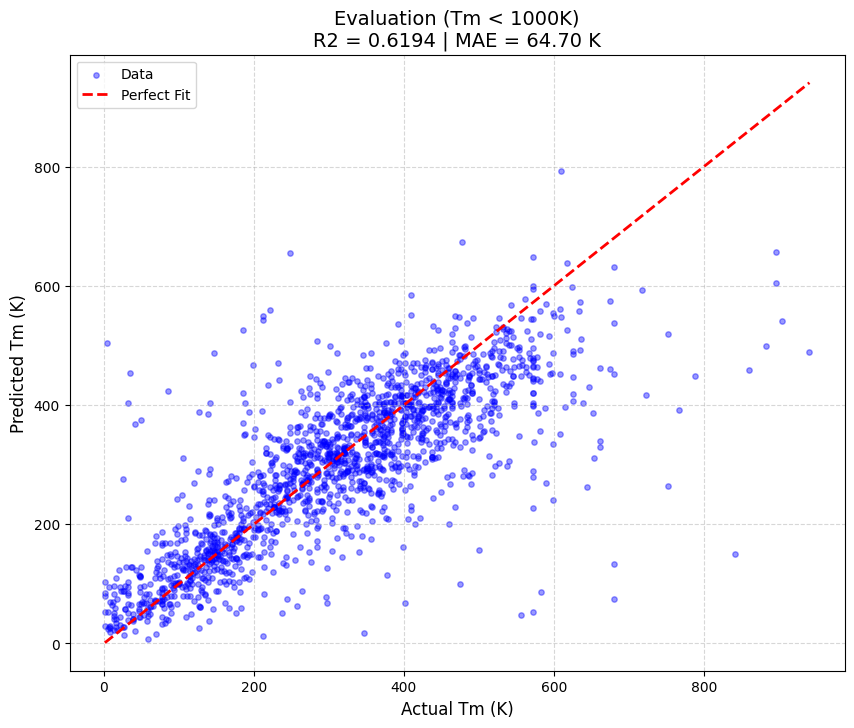

['result/model/final_features.pkl']

In [34]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
df = df.dropna(subset=['Tm'])

df = df[(df['Tm'] > 0) & (df['Tm'] < 1000)].copy()

print(f"Data size after removing outliers (>1000K): {len(df)}")

y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

y = y.reset_index(drop=True)
X = X.reset_index(drop=True)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='median')
X_final = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_log, test_size=0.2, random_state=2601)

corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.999)]

if to_drop:
    X_train = X_train.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)
    print(f"Dropped {len(to_drop)} high correlation features")

voting_model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=-1,
    verbose=-1
)

voting_model.fit(X_train, y_train)

y_pred_log = voting_model.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

new_r2 = r2_score(y_test_real, y_pred_real)
mae_real = mean_absolute_error(y_test_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("\n--- RESULT ---")
print(f"R2 Score : {new_r2:.4f}")
print(f"MAE      : {mae_real:.4f} K")
print(f"RMSE     : {rmse_real:.4f} K")

plt.figure(figsize=(10, 8))
plt.scatter(y_test_real, y_pred_real, alpha=0.4, color='blue', s=15, label='Data')

max_val = max(y_test_real.max(), y_pred_real.max())
min_val = min(y_test_real.min(), y_pred_real.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')

plt.title(f'Evaluation (Tm < 1000K)\nR2 = {new_r2:.4f} | MAE = {mae_real:.2f} K', fontsize=14)
plt.xlabel('Actual Tm (K)', fontsize=12)
plt.ylabel('Predicted Tm (K)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

joblib.dump(voting_model, 'result/model/final_melting_point_model.pkl')
joblib.dump(list(X_train.columns), 'result/model/final_features.pkl')

### Phân tích Kết quả Thực nghiệm (Phạm vi )

**1. Kết quả Định lượng:**
Sau khi loại bỏ các giá trị ngoại lai và lọc bỏ các đặc trưng tương quan cao, mô hình đạt:

* Mức độ giải thích biến thiên dữ liệu ở mức trung bình khá.
* Sai số tuyệt đối trung bình khoảng 65 độ.

**2. Đánh giá Nguyên nhân Biến động:**
So với thử nghiệm trên tập dữ liệu toàn phần (bao gồm cả chất vô cơ/muối), các chỉ số này phản ánh chính xác hiệu năng trên nhóm hợp chất hữu cơ:

* **Hiện tượng Hạn chế Phạm vi (Range Restriction):** Việc loại bỏ miền giá trị cao () làm giảm phương sai tổng thể của tập dữ liệu. Về mặt toán học, điều này khiến  giảm tự nhiên, đòi hỏi mô hình phải có độ nhạy cao hơn để phân biệt các mẫu có nhiệt độ gần nhau.
* **Độ chính xác thực tế (Honest Baseline):** Mức  là sai số thực tế khi loại bỏ ảnh hưởng của các điểm dữ liệu cực đoan (outliers). Biểu đồ phân tán cho thấy hiện tượng "co về trung bình" (regression to the mean), khi mô hình có xu hướng dự đoán thấp hơn thực tế ở vùng nhiệt độ cao (600-800K) và cao hơn thực tế ở vùng nhiệt độ thấp (<200K).

**Kết luận:** Đây là kết quả cơ sở (baseline) tin cậy cho bài toán dự đoán trên hợp chất hữu cơ, loại bỏ hoàn toàn các yếu tố gây nhiễu hoặc "ảo giác thống kê" từ các giá trị ngoại lai.

---